In this project, we will create a simple GAN to generate images similar to the Fashion-MNIST dataset

In [2]:
import tensorflow as tf
from tensorflow import keras
print('tensorflow version: {}'.format(tf.__version__))
print('keras version: {}'.format(keras.__version__))

tensorflow version: 2.1.0
keras version: 2.2.4-tf


## Download the fashion_mnist dataset

In [3]:
# import the fashion_MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [6]:
print('shape of X_train: {}'.format(X_train.shape))
print('shape of y_train: {}'.format(y_train.shape))
print('shape of X_test: {}'.format(X_test.shape))
print('shape of y_test: {}'.format(y_test.shape))

shape of X_train: (60000, 28, 28)
shape of y_train: (60000,)
shape of X_test: (10000, 28, 28)
shape of y_test: (10000,)


#### Visualize a bunch of random images in the dataset

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
img_idx = np.random.randint(low = 0, high = 60000, size = 16)

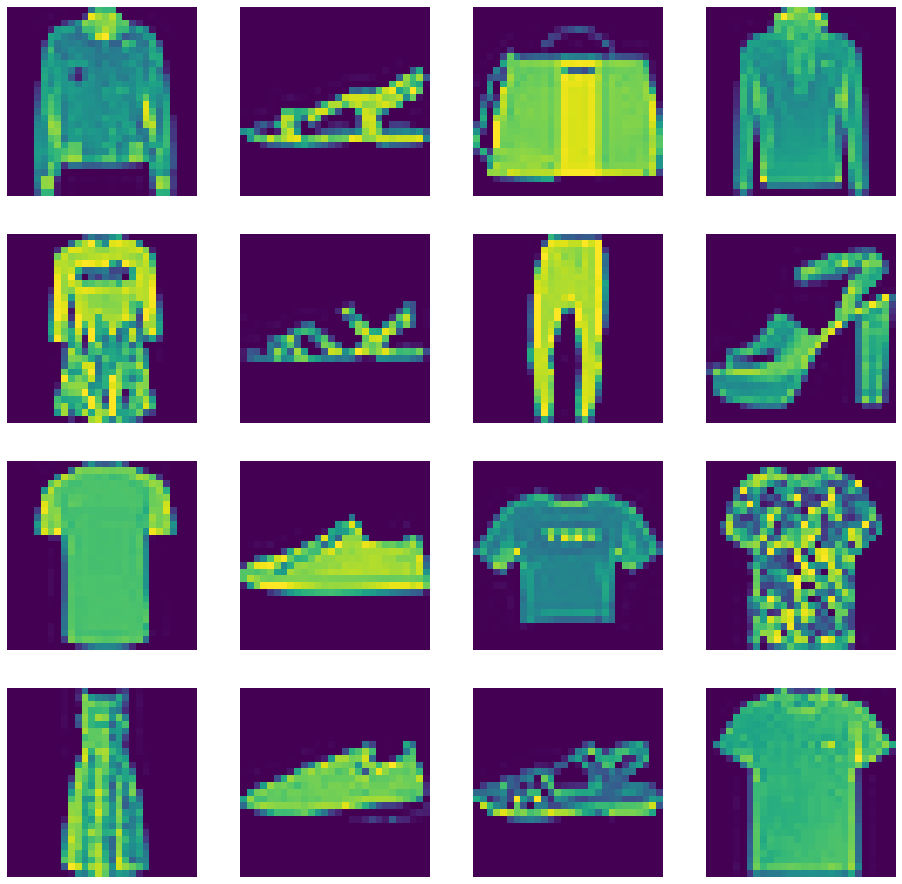

In [16]:
fig, ax = plt.subplots(figsize = (16, 16), nrows = 4, ncols = 4)
ctr = 0
for row in range(4):
    for col in range(4):
        ax[row, col].imshow(X_train[img_idx[ctr]])
        ax[row, col].axis('off')
        ctr+=1
       